<a href="https://colab.research.google.com/github/jollactic/Modelling_course/blob/main/CE_MC/Tutorial_LMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/jollactic/Modelling_course/main/CE_MC/DFT_norm.db
!wget https://raw.githubusercontent.com/jollactic/Modelling_course/main/CE_MC/helper.py

In [ ]:
!pip install icet
!pip install py3dmol

# Li intercalation in $LiMn_2O_4$ 

In this tutorial we will build a cluster expansion (CE) model for $LiMn_2O_4$ and try to compute a voltage profile. We use a data-set of DFT calculated energies to fit a cluster expansion model. We will use a code called Ice-T.

Mn and O atoms makes up the host of this intercalation material. Li can be filled into vacant holes in the structure. When using a CE model we need to point out exactly where this positions are located in the strucutre. This is done by using a template strucutre where "X" marks the spot. Thus vacancies, "X", and lithium ions, "Li", are treated in the same way as two components of alloy. See Ag-Pd example from the Ice-T page: https://icet.materialsmodeling.org/background/index.html which also provide details of all the command used in this tutorial.





### The magic number 7!

Often in these CE-codes everything is phrased in terms of atom concentrations rather than in terms of number of atoms. This means that we need to know the natural bounds of e.g. Li in the structure. Since Li makes up 1/7 of the atoms in the  formula $LiMn_2O_4$ (1+2+4=7) we need to normlize accordingly. Therefore the number 7 appear as a factor at some places in this example...



# 0. A rough estimate of the voltage profile

### Use the DFT energies provided below to make an estimate of the expected voltage profile from a battery using LMO as the intercalating material.

Tip #1: Nearst equation...

Tip #2: Faradays constant is 1 when the energy unit is eV!

The DFT energies provided are the results of an geometry optimization where both the cell and coordinates of the atoms have been optimized.

What important energy contributions are we neglecting when using these DFT energies?

In [ ]:
from ase.db import connect
from icet import ClusterSpace, StructureContainer, ClusterExpansion
from trainstation import CrossValidationEstimator
from ase.io import read
from helper import show

db = connect('DFT_norm.db')

# Some useful and importnant DFT reference energies
E_Li_metal=-1.9              # The energy for Li-metal (eV)
E_MO  =   -.34377483E+03 /8. # The energy for a "formula unit" of the host material Mn2O4 (eV)
E_LMO =   -.38704327E+03 /8. # The energy for a formula unit of the lithiated material LiMn2O4 (eV)

OCV_ref=-(E_LMO-E_MO-E_Li_metal) 

### Next we will consider a more realistic situation where the intercalation happens gradually, i.e. where we move (almost) continously from $Mn_2O_4$ to $LiMn_2O_4$

In order to adress this we make use of an cluster expansion approach. You are provided a small data-base with precomputed DFT energies for a number of cases with varying Li content ($Li_xMn2O4$). These are generated from $2\times 2 \times2$ repetitions of the crystallografic $LiMn_2O_4$ cells. For each structure in the data-base, some Li atoms have been removed at random.

The idea is now to fit a so-called cluster expansion model to reproduce the energies in the data-base. With a fitted model we can target much larger systems and explore the way that Li prefers to order on the lattice in a systematic way.


# 1. Fit the cluster expansion model

In [ ]:
# step 1: Basic setup

primitive_structure=db.get("id=1").toatoms()
#primitive_structure = read("template.POSCAR") # This is the template structure describing the lattice
# If you recall how to, you can visualize it! 

chemical_symbols=[]
for c in primitive_structure.symbols:
    if c == "Li" or c == "X":
        c= ["Li","X"]
    else:
        c=[c]
    chemical_symbols.append(c)
    
# step 2: Set up the basic structure and a cluster space
# Setting reasonable values in the cuttofs is the key to get a good model... 
cs = ClusterSpace(structure=primitive_structure,
                  cutoffs=[8.0,6.0],
                  chemical_symbols=chemical_symbols)
print(cs)

# step 3: Parse the input structures and set up a structure container
sc = StructureContainer(cluster_space=cs)
for row in db.select(): 
    sc.add_structure(structure=row.toatoms(),
                     properties={'mixing_energy': row.mixing_energy})
print(sc)

# step 4: Train parameters
opt = CrossValidationEstimator(fit_data=sc.get_fit_data(key='mixing_energy'),fit_method='ardr')
opt.validate()
opt.train()
print(opt)

# step 5: Construct cluster expansion and write it to file
ce = ClusterExpansion(cluster_space=cs, parameters=opt.parameters, metadata=opt.summary)
print(ce)
ce.write('mixing_energy.ce')

### The quality of the fitted cluster expansion parameters can be checked comparing energies predicted with the CE-model and those computed with DFT.

### 

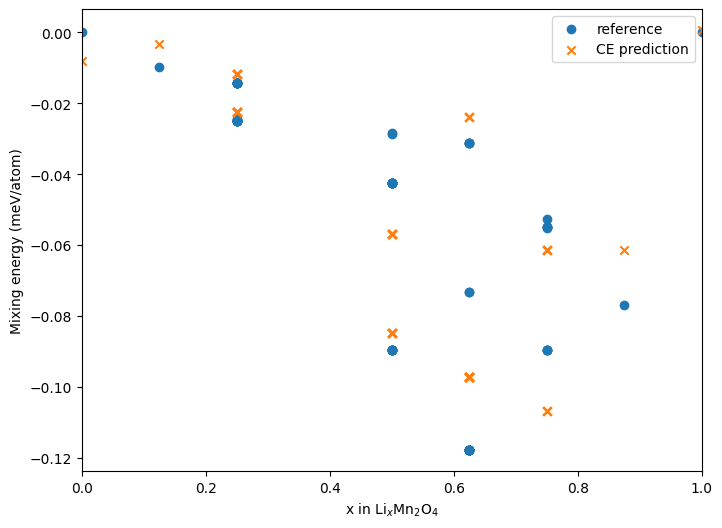

In [ ]:
import matplotlib.pyplot as plt
from ase.db import connect
from icet import ClusterExpansion

# step 1: Compile predicted and reference data for plotting
ce = ClusterExpansion.read('mixing_energy.ce')
data = {'x': [], 'reference_energy': [], 'predicted_energy': []}
for row in db.select():
    data['reference_energy'].append(row.mixing_energy)
    data['predicted_energy'].append(ce.predict(row.toatoms()))
    aa=row.toatoms()
    N=len(aa)
    mask= aa.symbols == "Li"
    N_Li= len(aa[mask])
    data['x'].append(N_Li*7.0/N)
# step 2: Plot results
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r'x in Li$_x$Mn$_2$O$_4$')
ax.set_ylabel(r'Mixing energy (meV/atom)')
ax.set_xlim([0, 1])
ax.scatter(data['x'], data['reference_energy'],
           marker='o', label='reference')
ax.scatter(data['x'], data['predicted_energy'],
           marker='x', label='CE prediction')
ax.legend()

### We can inspect the CE coefficients in the following plot.

In [ ]:
import matplotlib.pyplot as plt
from icet import ClusterExpansion
import numpy as np

# step 1: Collect ECIs in dictionary
ce = ClusterExpansion.read('mixing_energy.ce')
df_ecis = ce.to_dataframe()

# step 2: Plot ECIs
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
for k, order in enumerate(ce.orders):
    df_order = df_ecis.loc[df_ecis['order'] == order]
    if k < 2 or k > 4:
        continue
    ax = axs[k - 2]
    #ax.set_ylim((-1, 8))
    ax.set_xlabel(r'Cluster radius (Å)')
    ax.text(0.05, 0.55, 'zerolet: {:.1f} meV'
            .format(1e3 * df_ecis.eci.iloc[0]),
            transform=ax.transAxes)
    ax.text(0.05, 0.45, 'singlet: {:.1f} meV'
            .format(1e3 * df_ecis.eci.iloc[1]),
            transform=ax.transAxes)
    ax.plot([0, 5], [0, 0], color='black')
    ax.bar(df_order.radius, 1e3 * df_order.eci, width=0.05)
    ax.scatter(df_order.radius, len(df_order) * [-0.7],
               marker='o', s=2.0)
    ax.text(0.05, 0.91, 'order: {}'.format(order),
            transform=ax.transAxes)
    ax.text(0.05, 0.81, '#parameters: {}'.format(len(df_order)),
            transform=ax.transAxes,)
    ax.text(0.05, 0.71, '#non-zero params: {}'
            .format(np.count_nonzero(df_order.eci)),
            transform=ax.transAxes,)

# 2. Generate new strucutres
### We can use the CE model to generate much more structures, mote than we could ever afford to do with DFT.

The `enumerate_structures` function systematically generates structures by filling in the ['X','Li'] sublattice "combinatoriacally".

In [ ]:
import matplotlib.pyplot as plt
from numpy import array
from icet import ClusterExpansion
from icet.tools import ConvexHull, enumerate_structures

# step 1: Predict energies for enumerated structures
ce = ClusterExpansion.read('mixing_energy.ce')
species = ['Li', 'X','Mn','O']
data = {'concentration': [], 'mixing_energy': [],'x':[]}
structures = []
cluster_space = ce.get_cluster_space_copy()
chemical_symbols = cluster_space.chemical_symbols
primitive_structure = cluster_space.primitive_structure
for structure in enumerate_structures(structure=primitive_structure,
                                      sizes=range(1,8),
                                      chemical_symbols=chemical_symbols):
    conc = structure.get_chemical_symbols().count('Li') / len(structure)
    data['concentration'].append(conc)
    data['x'].append(conc*7.0)
    data['mixing_energy'].append(ce.predict(structure)) 
    structures.append(structure)
print('Predicted energies for {} structures'.format(len(structures)))

# step 2: Construct convex hull
hull = ConvexHull(data['x'], data['mixing_energy'])

# step 3: Plot the results
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xlabel(r'x in Li$_x$Mn$_2$O$_4$')
ax.set_ylabel(r'Mixing energy (eV/atom)')
ax.scatter(data['x'], array(data['mixing_energy']),
           marker='x')
ax.plot(hull.concentrations,  hull.energies, '-o', color='green')
plt.show()

# step 4: Extract candidate ground state structures
tol = 0.0005
low_energy_structures = hull.extract_low_energy_structures(
    data['x'], data['mixing_energy'], tol)
print('Found {} structures within {} meV/atom of the convex hull'.
      format(len(low_energy_structures), 1e3 * tol))

# 3. An improved voltage profile 
### hull.concentrations and  hull.energies (shown by the green curve in the plot above) can be used to estimate a voltage profile.

The slope can be seen as an approximation to $\Delta G$...

Try computing them!

# 4. Performing Monte-Carlo simulations

With Monte-Carlo simulation we can introduce temperature to the mix!

We can use a number of different ensambles when performing MC. The most useful ones here are:

1. Canonical ensamble (N,V,T fixed). With this ensamble we can calculate the average internal energy U.

2. (Semi) Grand canonocal ensamble (V,T, chemical potential fixed). Chemical potential and voltage can be related via Nearnst equation...

(Note! that our zero level for the chemical potential of Li is related to $LiMn_2O_4$ and $Mn_2O_4$ and not to Li-metal. We need to take this into account when relating voltage and "our" chemcial potential)

When running a MC simulation we are generating a collection of strucutres that represents what is typical at the specified conditions (V, T etc.). This collection is saved to a file and can be used to compute thermal average properties. (This is done separatelly below).

More details about how to control the MC simulations can be found here:
https://icet.materialsmodeling.org/tutorial/run_monte_carlo.html

In [ ]:
from ase.build import make_supercell
from icet import ClusterExpansion
from mchammer.calculators import ClusterExpansionCalculator
from mchammer.ensembles import SemiGrandCanonicalEnsemble
from mchammer.ensembles import CanonicalEnsemble
import numpy as np
from os import mkdir

# step 1: Set up structure to simulate as well as calculator
ce = ClusterExpansion.read('mixing_energy.ce')
structure = make_supercell(ce.get_cluster_space_copy().primitive_structure,
                           4 * np.array([[-1, 1, 1],
                                         [1, -1, 1],
                                         [1, 1, -1]]))
calculator = ClusterExpansionCalculator(structure, ce)

# step 2: Carry out Monte Carlo simulations and write to files
# Make sure output directory exists
output_directory = 'monte_carlo_data'
try:
    mkdir(output_directory)
except FileExistsError:
    pass

for temperature in [300]:
    # We can calculate the average Li content as a function of Li chemical potential
    for dmu in np.arange(-4.0 , +4.0, 1.0):
        # Initialize MC ensemble
        mc = SemiGrandCanonicalEnsemble(
            structure=structure,
            calculator=calculator,
            temperature=temperature,
            dc_filename='{}/sgc-T{}-dmu{:+.3f}.dc'.format(output_directory, temperature, dmu),
            chemical_potentials={'X': 0, 'Li': dmu})

        mc.run(number_of_trial_steps=  100000)
        structure = mc.structure

for temperature in [300]:
    # We can calculate the average internal energy as a function of x
    for x in np.arange(0.0, 1.0, 0.1):
        

        # We need to insert the correct number of Li and X into the structure
        N_Li_and_X=int( len(structure)/7)
        N_Li = round( x*N_Li_and_X)
        actual_x= float(N_Li)/float(N_Li_and_X)
        mask=N_Li_and_X*['X']
        mask[0:N_Li]=N_Li*['Li']     
        symbols= structure.symbols
        symbols[(symbols == 'X') | (symbols == 'Li')]=mask
        structure.symbols=symbols

        
        # Run canonical MC and save to file 
        if N_Li >0: 
          print("Running Canonical MC at x=",actual_x)
          # Initialize MC ensemble
          mc = CanonicalEnsemble(
              structure=structure,
              calculator=calculator,
              temperature=temperature,
              dc_filename='{}/NVT-T{}-x{}.dc'.format(output_directory, temperature,actual_x))

          mc.run(number_of_trial_steps=  100000)
          structure = mc.structure


### Next we can read in results from the Ice-T output files, compute average properties and collect them in a neat pandas data-frame. This will making plotting and manipulation of data more convinient.

In [ ]:
import pandas as pd
from glob import glob
from mchammer import DataContainer

#Collect data from SGC
data = []
for filename in glob('monte_carlo_data/sgc-*.dc'):
    dc = DataContainer.read(filename)
    data_row = dc.ensemble_parameters
    data_row['filename'] = filename
    n_atoms = data_row['n_atoms']

    equilibration = 1000

    stats = dc.analyze_data('Li_count', start=equilibration)
    data_row['Li_concentration'] = stats['mean'] / n_atoms
    data_row['x']=data_row['Li_concentration']*7.
    data_row['Li_concentration_error'] = stats['error_estimate'] / n_atoms

    stats = dc.analyze_data('potential', start=equilibration)
    data_row['mixing_energy'] = stats['mean'] / n_atoms
    data_row['mixing_energy_error'] = stats['error_estimate'] / n_atoms

    data_row['acceptance_ratio'] = \
        dc.get_average('acceptance_ratio', start=equilibration)
 
    data_row['free_energy_derivative'] = \
        (dc.ensemble_parameters['mu_Li'] - \
        dc.ensemble_parameters['mu_X'])/7.

    data.append(data_row)

# Make pandas dataframe in csv format
df_sgc = pd.DataFrame(data)


#Collect data from NVT
data = []
for filename in glob('monte_carlo_data/NVT-*.dc'):
    dc = DataContainer.read(filename)
    data_row = dc.ensemble_parameters
    data_row['filename'] = filename
    n_atoms = data_row['n_atoms']
    n_Li    = data_row['n_atoms_Li']
    equilibration = 1000

    data_row['x']= float(n_Li)/(float(n_atoms)/7.)

    stats = dc.analyze_data('potential', start=equilibration)
    data_row['mixing_energy'] = stats['mean'] / n_atoms
    data_row['mixing_energy_error'] = stats['error_estimate'] / n_atoms

    data_row['acceptance_ratio'] = \
        dc.get_average('acceptance_ratio', start=equilibration)


    data.append(data_row)

# step 2: Make pandas dataframe
df_NVT = pd.DataFrame(data)

#Calculate dG/dx
dE=np.diff(df_NVT['mixing_energy']  +df_NVT['x']*E_LMO + (1-df_NVT['x'])*E_MO)
x=df_NVT['x']
dx=np.diff(x)

dG = - (dE/dx - E_Li_metal)

V_NVT = [[G,G] for G in dG]
V_NVT = np.array(V_NVT).flatten()
X_NVT = []
for i in range(len(x)-1):
    X_NVT.extend([x[i],x[i+1]])   


### Plot the profiles